In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv


In [3]:
covid_impact_on_airport_traffic = pd.read_csv("../input/covid19s-impact-on-airport-traffic/covid_impact_on_airport_traffic.csv")

In [4]:
from datetime import date
import os

import geopandas as gpd
import geoplot
import folium
import mapclassify
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import plotly.express as px
import re
import seaborn as sns
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon 

In [5]:
covid_impact_on_airport_traffic.head()

,AggregationMethod,Date,Version,AirportName,PercentOfBaseline,Centroid,City,State,ISO_3166_2,Country,Geography
0,Daily,2020-04-03,1.0,Kingsford Smith,64,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
1,Daily,2020-04-13,1.0,Kingsford Smith,29,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
2,Daily,2020-07-10,1.0,Kingsford Smith,54,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
3,Daily,2020-09-02,1.0,Kingsford Smith,18,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."
4,Daily,2020-10-31,1.0,Kingsford Smith,22,POINT(151.180087713813 -33.9459774986125),Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1..."


Data description from the data file -

* AggregationMethod - Aggregation Period is used to calculate this metric
* Date - Date Traffic volume measured, in format YYYY-MM-DD
* Version: Version of this dataset
* AirportName: Name of airport
* PercentOfBaseline: Proportion of trips on this date as compared to Avg number of trips on the same day of week in baseline period i.e 1st February 2020 - 15th March 2020
* Centroid: Geography representing centroid of the Airport polygon
* City: City within which the Airport is located
* State: State within which the Airport is located
* ISO_3166_2: ISO-3166-2 code representing Country and Subdivision
* Country: Country within which the Airport is located
* Geography: Polygon of the Airport that is used to compute this metric

In [6]:
covid_impact_on_airport_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7247 entries, 0 to 7246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AggregationMethod  7247 non-null   object 
 1   Date               7247 non-null   object 
 2   Version            7247 non-null   float64
 3   AirportName        7247 non-null   object 
 4   PercentOfBaseline  7247 non-null   int64  
 5   Centroid           7247 non-null   object 
 6   City               7247 non-null   object 
 7   State              7247 non-null   object 
 8   ISO_3166_2         7247 non-null   object 
 9   Country            7247 non-null   object 
 10  Geography          7247 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 622.9+ KB


We can observe that there are no null values.

# Data Preprocessing

In [7]:
covid_impact_on_airport_traffic['Date'] = covid_impact_on_airport_traffic['Date'].map(lambda x:date.fromisoformat(x))

In [8]:
#Creating weekday column from date column
covid_impact_on_airport_traffic['weekday'] = covid_impact_on_airport_traffic['Date'].map(lambda x:x.weekday())
w_list = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
covid_impact_on_airport_traffic["weekday"] = [w_list[idx] for idx in covid_impact_on_airport_traffic["weekday"]]

In [9]:
def cut_long(point):
    long, _ = point[6:-1].split(" ")
    return float(long)

def cut_lat(point):
    _, lat = point[6:-1].split(" ")
    return float(lat)

In [10]:
covid_impact_on_airport_traffic['long']= covid_impact_on_airport_traffic['Centroid'].map(cut_long)
covid_impact_on_airport_traffic['lat'] = covid_impact_on_airport_traffic['Centroid'].map(cut_lat)

In [11]:
need_columns = [col for col in covid_impact_on_airport_traffic.columns if col not in ['AggregationMethod', 'Version', 'Centroid']]
covid_impact_on_airport_traffic = covid_impact_on_airport_traffic[need_columns] 

In [12]:
covid_impact_on_airport_traffic.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-04-13,Kingsford Smith,29,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Mon,151.180088,-33.945977
2,2020-07-10,Kingsford Smith,54,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
3,2020-09-02,Kingsford Smith,18,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Wed,151.180088,-33.945977
4,2020-10-31,Kingsford Smith,22,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Sat,151.180088,-33.945977


Create a new dataframe where the AirportName is unique. We will use it for plotting on folium later.

In [13]:
covid_impact_on_airport_traffic_unique = covid_impact_on_airport_traffic[~covid_impact_on_airport_traffic[['AirportName']].duplicated()].reset_index(drop=True)
covid_impact_on_airport_traffic_unique

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977
1,2020-03-17,Santiago International Airport,72,Santiago,Santiago Province,CL,Chile,"POLYGON((-70.8043956756592 -33.3719683869737, ...",Tue,-70.794237,-33.390727
2,2020-04-05,Calgary International,65,Calgary,Alberta,CA-AB,Canada,"POLYGON((-113.981866836548 51.1392131913567, -...",Sun,-114.013123,51.118475
3,2020-04-20,Edmonton International,46,Leduc County,Alberta,CA-AB,Canada,"POLYGON((-113.568120002747 53.3110445425655, -...",Mon,-113.576261,53.308783
4,2020-05-15,Vancouver International,68,Richmond,British Columbia,CA-BC,Canada,"POLYGON((-123.136525154114 49.1980971490671, -...",Fri,-123.177541,49.193579
5,2020-05-27,Winnipeg International,100,Winnipeg,Manitoba,CA-MB,Canada,"POLYGON((-97.2094345092773 49.8979517850609, -...",Wed,-97.219062,49.902471
6,2020-03-29,Halifax International,32,Halifax,Nova Scotia,CA-NS,Canada,"POLYGON((-63.5266613960266 44.8984438169036, -...",Sun,-63.511672,44.883017
7,2020-04-10,Toronto Pearson,10,Mississauga,Ontario,CA-ON,Canada,"POLYGON((-79.6076846122742 43.6972621366144, -...",Fri,-79.631344,43.679352
8,2020-08-10,Hamilton International,100,Hamilton,Ontario,CA-ON,Canada,"POLYGON((-79.932746887207 43.1551600161937, -7...",Mon,-79.926693,43.172036
9,2020-09-16,Montreal Mirabel,100,Mirabel,Quebec,CA-QC,Canada,"POLYGON((-74.0895652770996 45.6856314730097, -...",Wed,-74.048380,45.681503


# Data Analysis and Visualization

In [14]:
def visualize_airport_map(df,  zoom):
    
    lat_map=30.038557
    lon_map=31.231781
    f = folium.Figure(width=1000, height=500)
    m = folium.Map([lat_map,lon_map], zoom_start=zoom).add_to(f)
        
    for i in range(0,len(df)):
        folium.Marker(location=[df["lat"][i],df["long"][i]],icon=folium.Icon(icon_color='white',icon ='plane',prefix='fa')).add_to(m)
        
    return m

In [15]:
visualize_airport_map(covid_impact_on_airport_traffic_unique, 1)

Text(0.5, 1.0, 'records for each country')

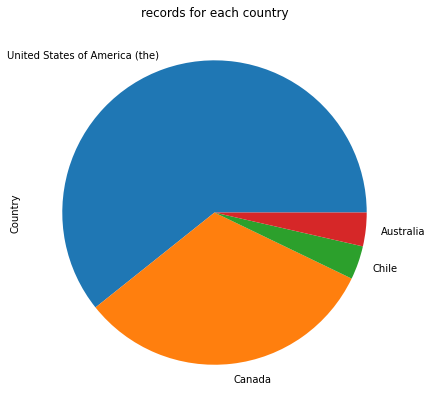

In [16]:
#Checking the count of records for each country

df_country_count = covid_impact_on_airport_traffic_unique['Country'].value_counts()
g = df_country_count.plot.pie(y='Country', figsize=(7, 7))
g.set_title("records for each country")

Text(0.5, 1.0, 'records for each airport')

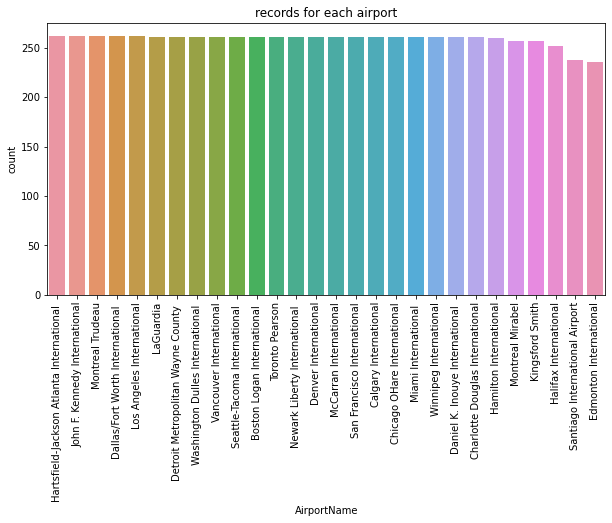

In [17]:
#counting the number of records for each airport
plt.figure(figsize=(10, 5))
g = sns.countplot(data=covid_impact_on_airport_traffic, x="AirportName",
              order = covid_impact_on_airport_traffic['AirportName'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_title("records for each airport")

In [18]:
#Creating a column 'month' to get the monthly data from the Date column
covid_impact_on_airport_traffic['month'] = covid_impact_on_airport_traffic['Date'].map(lambda x:x.month)

covid_impact_on_airport_traffic.head()

,Date,AirportName,PercentOfBaseline,City,State,ISO_3166_2,Country,Geography,weekday,long,lat,month
0,2020-04-03,Kingsford Smith,64,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977,4
1,2020-04-13,Kingsford Smith,29,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Mon,151.180088,-33.945977,4
2,2020-07-10,Kingsford Smith,54,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Fri,151.180088,-33.945977,7
3,2020-09-02,Kingsford Smith,18,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Wed,151.180088,-33.945977,9
4,2020-10-31,Kingsford Smith,22,Sydney,New South Wales,AU,Australia,"POLYGON((151.164354085922 -33.9301772341877, 1...",Sat,151.180088,-33.945977,10


In [19]:
#Creating a dataframe with month and the count of each month
dfa = covid_impact_on_airport_traffic.groupby(by = [covid_impact_on_airport_traffic['month']])['Date'].count().rename('Counts').to_frame()
dfa = dfa.reset_index()
dfa

,month,Counts
0,3,445
1,4,825
2,5,855
3,6,831
4,7,862
5,8,835
6,9,835
7,10,868
8,11,835
9,12,56


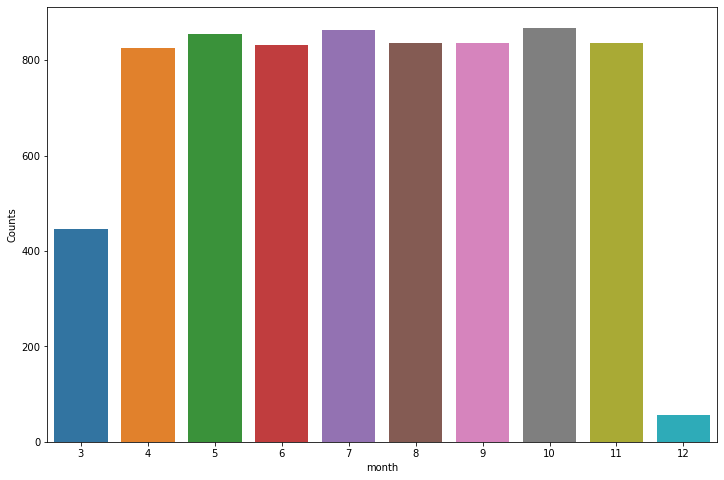

In [20]:
#plotting the dataframe to see the busiest of months
plt.figure(figsize = (12,8))
sns.barplot( x = 'month', y = 'Counts', data = dfa)

Text(0.5, 1.0, 'records for each weekday')

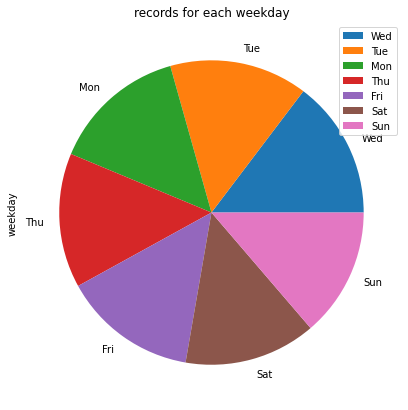

In [21]:
#Creating a pie chart visualization of the days of week that are the busiest
df_weekday_count = pd.DataFrame(covid_impact_on_airport_traffic["weekday"].value_counts())
g = df_weekday_count.plot.pie(y='weekday', figsize=(7, 7))
g.set_title("records for each weekday")

Creating some visualizations with PercentOfBaseling using Geopandas and see how it changes on a day of the week and on a monthly basis.

In [22]:
#Creating a Geometry dataframe
df_geometry = covid_impact_on_airport_traffic_unique[['AirportName', 'City', 'State',
                                                     'ISO_3166_2', 'Country', 'long', 'lat']]

Lets calculate the mean of PercentOfBaseline across each weekday and then a month. We will use this data to plot geopandas world plots to see which airport has a maximum
mean PercentOfBaseline on a particular weekday and month

In [23]:
df_airport_weekday_mean = covid_impact_on_airport_traffic[['AirportName','weekday','PercentOfBaseline']].groupby(['AirportName','weekday']).mean()
df_airport_weekday_mean = df_airport_weekday_mean.reset_index()
df_airport_weekday_mean = df_airport_weekday_mean.merge(df_geometry, on="AirportName")
df_airport_weekday_mean.head()

,AirportName,weekday,PercentOfBaseline,City,State,ISO_3166_2,Country,long,lat
0,Boston Logan International,Fri,63.567568,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
1,Boston Logan International,Mon,64.162162,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
2,Boston Logan International,Sat,62.432432,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
3,Boston Logan International,Sun,63.351351,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633
4,Boston Logan International,Thu,61.432432,Boston,Massachusetts,US-MA,United States of America (the),-71.010291,42.363633


In [24]:
#extracting data for Saturday

df_airport_weekday_mean_sat = df_airport_weekday_mean[df_airport_weekday_mean['weekday'] == 'Sat']
gdf_airport_weekday_mean_sat = gpd.GeoDataFrame(df_airport_weekday_mean_sat, geometry = gpd.points_from_xy(df_airport_weekday_mean_sat.long, df_airport_weekday_mean_sat.lat))

Let's plot on the world map now

In [25]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


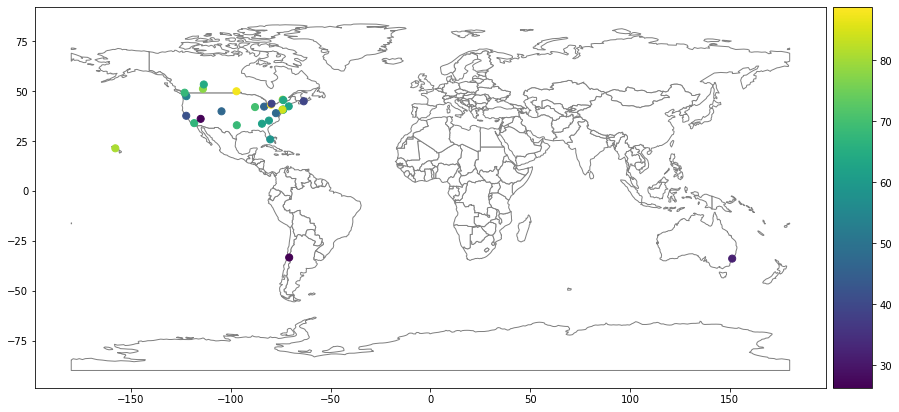

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_weekday_mean_sat.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()

We can plot similarly for all the other days

In [27]:
df_airport_date_mean = covid_impact_on_airport_traffic[["AirportName", "Date", "PercentOfBaseline"]]
df_airport_date_mean["Date"] = df_airport_date_mean["Date"].map(lambda d: d.month)
df_airport_date_mean = df_airport_date_mean.groupby(["AirportName", "Date"]).mean()
df_airport_date_mean = df_airport_date_mean.reset_index()
df_airport_date_mean = df_airport_date_mean.merge(df_geometry, on="AirportName")
df_airport_date_mean = df_airport_date_mean.rename(columns={"Date": "month"})

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


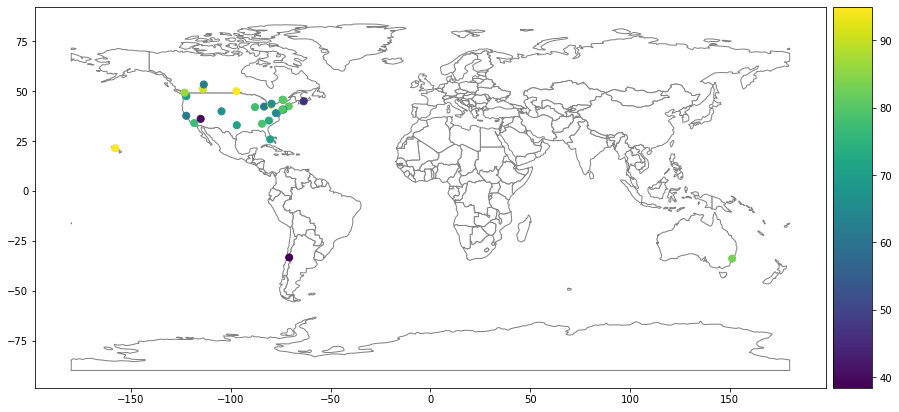

In [33]:
#Filtering by month and plotting using geopandas for March
df_airport_date_mean_march = df_airport_date_mean[df_airport_date_mean['month'] == 3]
gdf_airport_date_mean_march = gpd.GeoDataFrame(df_airport_date_mean_march, geometry = gpd.points_from_xy(df_airport_date_mean_march.long, df_airport_date_mean_march.lat))
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_date_mean_march.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()

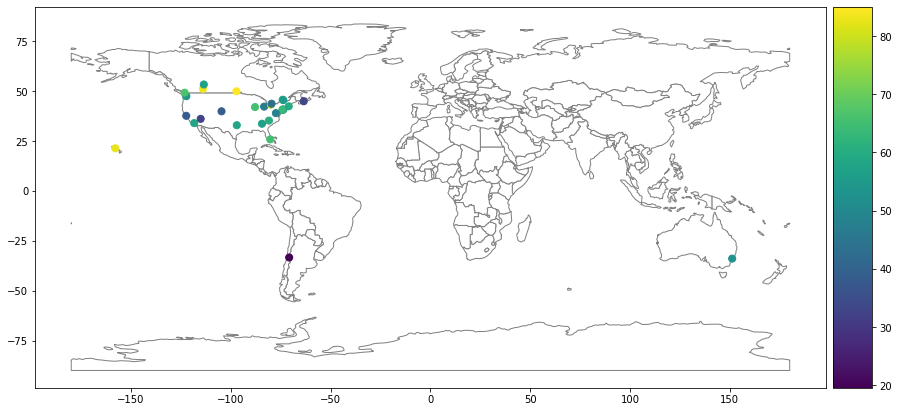

In [32]:
#Filtering by month and plotting using geopandas for April
df_airport_date_mean_april = df_airport_date_mean[df_airport_date_mean['month'] == 4]
gdf_airport_date_mean_april = gpd.GeoDataFrame(df_airport_date_mean_april, geometry = gpd.points_from_xy(df_airport_date_mean_april.long, df_airport_date_mean_april.lat))
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_date_mean_april.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()

In [ ]:
df_airport_date_mean_may = df_airport_date_mean[df_airport_date_mean['month'] == 5]
gdf_airport_date_mean_may = gpd.GeoDataFrame(df_airport_date_mean_may, geometry = gpd.points_from_xy(df_airport_date_mean_may.long, df_airport_date_mean_may.lat))
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

world.plot(ax=ax, color='white', edgecolor='gray')
gdf_airport_date_mean_may.plot(column='PercentOfBaseline', ax=ax, markersize=50, legend=True, cax=cax)
plt.show()